In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import warnings
from datetime import datetime
import openpyxl
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("="*100)
print("🎯 COMPREHENSIVE PORTFOLIO EVALUATION & COMPARISON")
print("="*100)

# ======================================================================
# 1. LOAD DATA & MODELS
# ======================================================================
print("\n[Step 1/8] Loading models, scalers, and data...")

try: 
    # Load ORIGINAL model
    model_original = tf.keras.models.load_model('..//saved_models//best_lstm_model.keras')
    print("  ✓ Original LSTM model loaded")

    # Load FILTERED model
    model_filtered = tf.keras.models.load_model('..//saved_models//best_lstm_model_filtered.keras')
    print("  ✓ Filtered LSTM model loaded")

    # Load scalers
    with open('..//standard_scalars//scaler_X.pkl', 'rb') as f:
        scaler_X_orig = pickle.load(f)
    with open('..//standard_scalars//scaler_y.pkl', 'rb') as f:
        scaler_y_orig = pickle.load(f)

    with open('..//standard_scalars//scaler_X_filtered.pkl', 'rb') as f:
        scaler_X_filt = pickle.load(f)
    with open('..//standard_scalars//scaler_y_filtered.pkl', 'rb') as f:
        scaler_y_filt = pickle.load(f)
    print("  ✓ Scalers loaded")

    # Load preprocessed data
    data_orig = np.load('..//saved_models//lstm_preprocessed_data.npz', allow_pickle=True)
    X_seq_orig = data_orig['X_seq']
    y_seq_orig = data_orig['y_seq']
    sequence_dates_orig = pd.to_datetime(data_orig['sequence_dates_values'])
    train_mask_orig = data_orig['train_mask']
    test_mask_orig = data_orig['test_mask']
    
    data_filt = np.load('..//saved_models//lstm_preprocessed_data_filtered.npz', allow_pickle=True)
    X_seq_filt = data_filt['X_seq']
    y_seq_filt = data_filt['y_seq']
    sequence_dates_filt = pd.to_datetime(data_filt['sequence_dates_values'])
    train_mask_filt = data_filt['train_mask']
    test_mask_filt = data_filt['test_mask']
    filtered_columns = data_filt['filtered_columns']
    print("  ✓ Data loaded")
    
    # Load original data
    df_orig = pd.read_csv('..//inputs_data//final_data.csv', index_col=0, parse_dates=True)
    print("  ✓ Original price data loaded")
    
except Exception as e:
    print(f"  ✗ Error: {e}")
    exit()

# ======================================================================
# 2. GENERATE PREDICTIONS FOR BOTH MODELS
# ======================================================================
print("\n[Step 2/8] Generating predictions for both models...")

# ORIGINAL MODEL
X_test_orig = X_seq_orig[test_mask_orig]
y_test_orig = y_seq_orig[test_mask_orig]
test_dates_orig = sequence_dates_orig[test_mask_orig]

y_pred_orig_scaled = model_original.predict(X_test_orig, verbose=0, batch_size=64)
y_pred_orig = scaler_y_orig.inverse_transform(y_pred_orig_scaled)
y_test_actual_orig = scaler_y_orig.inverse_transform(y_test_orig.reshape(-1, 1))

# FILTERED MODEL
X_test_filt = X_seq_filt[test_mask_filt]
y_test_filt = y_seq_filt[test_mask_filt]
test_dates_filt = sequence_dates_filt[test_mask_filt]

y_pred_filt_scaled = model_filtered.predict(X_test_filt, verbose=0, batch_size=64)
y_pred_filt = scaler_y_filt.inverse_transform(y_pred_filt_scaled)
y_test_actual_filt = scaler_y_filt.inverse_transform(y_test_filt.reshape(-1, 1))

print(f"  ✓ Original model: {len(y_pred_orig)} predictions")
print(f"  ✓ Filtered model: {len(y_pred_filt)} predictions")

# ======================================================================
# 3. GENERATE TRADING SIGNALS
# ======================================================================
print("\n[Step 3/8] Generating trading signals...")

# ORIGINAL MODEL SIGNALS
price_changes_orig = np.diff(y_pred_orig.flatten()) / y_pred_orig[:-1].flatten()
signals_orig = np.where(price_changes_orig > 0, 1, -1)
signals_orig = np.append(signals_orig, signals_orig[-1])  # Align length

# FILTERED MODEL SIGNALS
price_changes_filt = np.diff(y_pred_filt.flatten()) / y_pred_filt[:-1].flatten()
signals_filt = np.where(price_changes_filt > 0, 1, -1)
signals_filt = np.append(signals_filt, signals_filt[-1])  # Align length

print(f"  ✓ Original model: {np.sum(signals_orig > 0)} BUY signals, {np.sum(signals_orig < 0)} SELL signals")
print(f"  ✓ Filtered model: {np.sum(signals_filt > 0)} BUY signals, {np.sum(signals_filt < 0)} SELL signals")

# ======================================================================
# 4. ALIGN DATA & CREATE UNIFIED DATASET (FIXED)
# ======================================================================
print("\n[Step 4/8] Aligning data and creating unified dataset...")

# Use filtered model's test dates as reference
test_dates = test_dates_filt.copy()
y_actual = y_test_actual_filt.flatten()

# Create DataFrame with aligned data
df_prices_filt = pd.DataFrame({
    'date': test_dates,
    'actual_price': y_actual,
    'pred_price_filt': y_pred_filt.flatten(),
    'signal_filt': signals_filt
})

# Create buy & hold benchmark
df_prices_filt['bh_return'] = (df_prices_filt['actual_price'].pct_change()).fillna(0)

# Create filtered model returns
df_prices_filt['filtered_return'] = df_prices_filt['signal_filt'] * df_prices_filt['bh_return']

# ✅ FIX: Calculate transaction costs with correct alignment
TRANSACTION_COST = 0.001

# Get signal changes - this creates n-1 elements, so prepend 0
signal_changes_filt = np.diff(df_prices_filt['signal_filt'].values)
signal_changes_filt = np.append([0], signal_changes_filt)  # ✅ Prepend instead of append

# Calculate transaction costs with correct length
transaction_costs_filt = np.abs(signal_changes_filt) * TRANSACTION_COST / 2

# ✅ Ensure both arrays have the same length
assert len(transaction_costs_filt) == len(df_prices_filt), \
    f"Shape mismatch: transaction_costs ({len(transaction_costs_filt)}) vs df_prices_filt ({len(df_prices_filt)})"

df_prices_filt['filtered_return_net'] = df_prices_filt['filtered_return'] - transaction_costs_filt

print(f"  ✓ Aligned {len(df_prices_filt)} records")
print(f"  ✓ Transaction costs applied: {TRANSACTION_COST*100:.2f}% per trade")
print(f"  ✓ All arrays verified: {len(df_prices_filt)} rows")
# ======================================================================
# 5. CALCULATE CUMULATIVE RETURNS & PORTFOLIO METRICS
# ======================================================================
print("\n[Step 5/8] Calculating portfolio metrics...")

# Buy & Hold
df_prices_filt['bh_cumulative_return'] = (1 + df_prices_filt['bh_return']).cumprod() - 1

# Filtered Model
df_prices_filt['filtered_cumulative_return'] = (1 + df_prices_filt['filtered_return_net']).cumprod() - 1

# Calculate portfolio values (starting with $100,000)
INITIAL_CAPITAL = 100000

df_prices_filt['bh_portfolio_value'] = INITIAL_CAPITAL * (1 + df_prices_filt['bh_cumulative_return'])
df_prices_filt['filtered_portfolio_value'] = INITIAL_CAPITAL * (1 + df_prices_filt['filtered_cumulative_return'])

# Calculate metrics
def calculate_metrics(returns_series, portfolio_values):
    """Calculate comprehensive metrics"""
    
    total_return = (portfolio_values.iloc[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL
    
    # Annualized metrics
    trading_days = len(returns_series)
    years = trading_days / 252
    annualized_return = (1 + total_return) ** (1 / years) - 1
    
    # Volatility
    daily_volatility = returns_series.std()
    annualized_volatility = daily_volatility * np.sqrt(252)
    
    # Sharpe Ratio (risk-free rate = 0)
    sharpe_ratio = (annualized_return / annualized_volatility) if annualized_volatility > 0 else 0
    
    # Maximum Drawdown
    cumulative_returns = (1 + returns_series).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Hit Rate (Direction Accuracy)
    hits = np.sum(returns_series > 0)
    total = len(returns_series)
    hit_rate = hits / total if total > 0 else 0
    
    # Win/Loss stats
    avg_win = returns_series[returns_series > 0].mean() if len(returns_series[returns_series > 0]) > 0 else 0
    avg_loss = returns_series[returns_series < 0].mean() if len(returns_series[returns_series < 0]) > 0 else 0
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'hit_rate': hit_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'trading_days': trading_days,
        'final_value': portfolio_values.iloc[-1]
    }

metrics_bh = calculate_metrics(
    df_prices_filt['bh_return'], 
    df_prices_filt['bh_portfolio_value']
)

metrics_filtered = calculate_metrics(
    df_prices_filt['filtered_return_net'], 
    df_prices_filt['filtered_portfolio_value']
)

print(f"\n  Buy & Hold Metrics:")
print(f"   ├─ Total Return:        {metrics_bh['total_return']*100:>8.2f}%")
print(f"   ├─ Annualized Return:   {metrics_bh['annualized_return']*100:>8.2f}%")
print(f"   ├─ Annualized Vol:      {metrics_bh['annualized_volatility']*100:>8.2f}%")
print(f"   ├─ Sharpe Ratio:        {metrics_bh['sharpe_ratio']:>8.2f}")
print(f"   ├─ Max Drawdown:        {metrics_bh['max_drawdown']*100:>8.2f}%")
print(f"   ├─ Hit Rate:            {metrics_bh['hit_rate']*100:>8.2f}%")
print(f"   └─ Final Value:         ${metrics_bh['final_value']:>10,.0f}")

print(f"\n  LSTM Filtered Metrics:")
print(f"   ├─ Total Return:        {metrics_filtered['total_return']*100:>8.2f}%")
print(f"   ├─ Annualized Return:   {metrics_filtered['annualized_return']*100:>8.2f}%")
print(f"   ├─ Annualized Vol:      {metrics_filtered['annualized_volatility']*100:>8.2f}%")
print(f"   ├─ Sharpe Ratio:        {metrics_filtered['sharpe_ratio']:>8.2f}")
print(f"   ├─ Max Drawdown:        {metrics_filtered['max_drawdown']*100:>8.2f}%")
print(f"   ├─ Hit Rate:            {metrics_filtered['hit_rate']*100:>8.2f}%")
print(f"   └─ Final Value:         ${metrics_filtered['final_value']:>10,.0f}")

# ======================================================================
# 6. COMPARATIVE ANALYSIS
# ======================================================================
print("\n[Step 6/8] Generating comparative analysis...")

analysis = f"""
{'='*100}
📊 COMPARATIVE PORTFOLIO EVALUATION: LSTM MODELS VS BUY & HOLD
{'='*100}

1. PERFORMANCE COMPARISON
{'-'*100}

Metric                          Buy & Hold          LSTM Filtered       Difference (%)
{'-'*100}
Total Return                    {metrics_bh['total_return']*100:>8.2f}%              {metrics_filtered['total_return']*100:>8.2f}%              {(metrics_filtered['total_return']-metrics_bh['total_return'])*100:>+8.2f}%
Annualized Return               {metrics_bh['annualized_return']*100:>8.2f}%              {metrics_filtered['annualized_return']*100:>8.2f}%              {(metrics_filtered['annualized_return']-metrics_bh['annualized_return'])*100:>+8.2f}%
Annualized Volatility           {metrics_bh['annualized_volatility']*100:>8.2f}%              {metrics_filtered['annualized_volatility']*100:>8.2f}%              {(metrics_filtered['annualized_volatility']-metrics_bh['annualized_volatility'])*100:>+8.2f}%
Sharpe Ratio                    {metrics_bh['sharpe_ratio']:>8.2f}              {metrics_filtered['sharpe_ratio']:>8.2f}              {metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio']:>+8.2f}
Maximum Drawdown                {metrics_bh['max_drawdown']*100:>8.2f}%              {metrics_filtered['max_drawdown']*100:>8.2f}%              {(metrics_filtered['max_drawdown']-metrics_bh['max_drawdown'])*100:>+8.2f}%
Hit Rate (Direction Accuracy)   {metrics_bh['hit_rate']*100:>8.2f}%              {metrics_filtered['hit_rate']*100:>8.2f}%              {(metrics_filtered['hit_rate']-metrics_bh['hit_rate'])*100:>+8.2f}%

Final Portfolio Value           ${metrics_bh['final_value']:>10,.0f}         ${metrics_filtered['final_value']:>10,.0f}         ${metrics_filtered['final_value']-metrics_bh['final_value']:>+10,.0f}

{'-'*100}

2. KEY FINDINGS
{'-'*100}

A. RETURN ANALYSIS
   • Buy & Hold Strategy:
     - Generated a {metrics_bh['total_return']*100:.2f}% total return over {metrics_bh['trading_days']} trading days
     - Annualized return of {metrics_bh['annualized_return']*100:.2f}%
     - Final portfolio value: ${metrics_bh['final_value']:,.0f}
   
   • LSTM Filtered Strategy:
     - Generated a {metrics_filtered['total_return']*100:.2f}% total return
     - Annualized return of {metrics_filtered['annualized_return']*100:.2f}%
     - Final portfolio value: ${metrics_filtered['final_value']:,.0f}
     - Outperformance: {(metrics_filtered['total_return']-metrics_bh['total_return'])*100:+.2f}% (${metrics_filtered['final_value']-metrics_bh['final_value']:+,.0f})

B. RISK-ADJUSTED PERFORMANCE
   • Volatility Comparison:
     - B&H Annualized Vol: {metrics_bh['annualized_volatility']*100:.2f}%
     - LSTM Vol: {metrics_filtered['annualized_volatility']*100:.2f}%
     - Volatility Reduction: {(metrics_bh['annualized_volatility']-metrics_filtered['annualized_volatility'])*100:.2f}% {'✓ IMPROVED' if metrics_filtered['annualized_volatility'] < metrics_bh['annualized_volatility'] else '✗ INCREASED'}
   
   • Sharpe Ratio (Risk-Adjusted Return):
     - B&H Sharpe: {metrics_bh['sharpe_ratio']:.4f}
     - LSTM Sharpe: {metrics_filtered['sharpe_ratio']:.4f}
     - Improvement: {metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio']:+.4f} {'✓ SUPERIOR' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ INFERIOR'}
   
   • Maximum Drawdown:
     - B&H Max DD: {metrics_bh['max_drawdown']*100:.2f}%
     - LSTM Max DD: {metrics_filtered['max_drawdown']*100:.2f}%
     - Drawdown Reduction: {abs(metrics_bh['max_drawdown']-metrics_filtered['max_drawdown'])*100:.2f}% {'✓ BETTER' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else '✗ WORSE'}

C. DIRECTIONAL ACCURACY
   • Hit Rate (Direction Accuracy):
     - B&H (Passive): {metrics_bh['hit_rate']*100:.2f}% (always positive in uptrend)
     - LSTM Filtered: {metrics_filtered['hit_rate']*100:.2f}%
     - Interpretation: Model captures {metrics_filtered['hit_rate']*100:.2f}% of daily price movements correctly

D. WIN/LOSS ANALYSIS
   • Average Win: LSTM {metrics_filtered['avg_win']*100:+.3f}% vs B&H {metrics_bh['avg_win']*100:+.3f}%
   • Average Loss: LSTM {metrics_filtered['avg_loss']*100:+.3f}% vs B&H {metrics_bh['avg_loss']*100:+.3f}%
   • Win/Loss Ratio: {abs(metrics_filtered['avg_win']/metrics_filtered['avg_loss']):.2f}:1 (LSTM) vs {abs(metrics_bh['avg_win']/metrics_bh['avg_loss']):.2f}:1 (B&H)

{'-'*100}

3. CONCLUSIONS & INSIGHTS
{'-'*100}

{'✓ LSTM Outperforms' if metrics_filtered['total_return'] > metrics_bh['total_return'] else '✗ B&H Outperforms'}
The LSTM filtered model {'OUTPERFORMS' if metrics_filtered['total_return'] > metrics_bh['total_return'] else 'UNDERPERFORMS'} buy & hold by {abs(metrics_filtered['total_return']-metrics_bh['total_return'])*100:.2f}% 
in total returns, generating ${abs(metrics_filtered['final_value']-metrics_bh['final_value']):,.0f} 
{'additional profit' if metrics_filtered['final_value'] > metrics_bh['final_value'] else 'additional loss'}.

{'✓ Risk-Adjusted' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ Higher Risk'} Performance
The Sharpe ratio of {metrics_filtered['sharpe_ratio']:.4f} (LSTM) vs {metrics_bh['sharpe_ratio']:.4f} (B&H) indicates 
{'SUPERIOR' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'INFERIOR'} risk-adjusted returns. The model {'successfully' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'fails to'} 
generate returns commensurate with the risk taken.

{'✓ Reduced' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else '✗ Increased'} Drawdown Risk
The maximum drawdown of {metrics_filtered['max_drawdown']*100:.2f}% (LSTM) vs {metrics_bh['max_drawdown']*100:.2f}% (B&H) 
demonstrates {'BETTER' if abs(metrics_filtered['max_drawdown']) < abs(metrics_bh['max_drawdown']) else 'WORSE'} downside protection.

SHAP Feature Filtering Impact:
The filtered LSTM model uses {len(filtered_columns)} top SHAP features: {', '.join(filtered_columns)}
This reduction from the original feature set {'IMPROVES' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else 'DEGRADES'} model 
stability and {'REDUCES' if metrics_filtered['annualized_volatility'] < metrics_bh['annualized_volatility'] else 'INCREASES'} noise.

{'-'*100}

4. RECOMMENDATIONS
{'-'*100}

1. MODEL SELECTION:
   {'✓ RECOMMEND LSTM Filtered Model' if metrics_filtered['sharpe_ratio'] > metrics_bh['sharpe_ratio'] else '✗ RECOMMEND Buy & Hold'}
   
2. RISK MANAGEMENT:
   • Set maximum drawdown tolerance at {abs(metrics_filtered['max_drawdown'])*100:.2f}%
   • Implement stop-loss at {abs(metrics_filtered['max_drawdown'])*100*0.5:.2f}% to reduce tail risk
   
3. POSITION SIZING:
   • Based on Sharpe ratio of {metrics_filtered['sharpe_ratio']:.4f}, suggest allocating
     {min(100, max(0, (metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio'])*50)):.0f}% to LSTM strategy

4. REBALANCING:
   • Monitor model predictions weekly
   • Recalibrate SHAP features monthly
   • Update model every quarter with new data

{'-'*100}
{'='*100}
"""

print(analysis)

# ======================================================================
# 7. CREATE EXCEL EXPORT
# ======================================================================
print("\n[Step 7/8] Creating Excel export...")
excel_file = '..\\portfolio_results\\Portfolio_Evaluation_LSTM_vs_BuyHold.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    
    # Sheet 1: Daily Returns
    df_export = df_prices_filt[[
        'date', 'actual_price', 'bh_return', 'filtered_return_net',
        'bh_cumulative_return', 'filtered_cumulative_return',
        'bh_portfolio_value', 'filtered_portfolio_value'
    ]].copy()
    
    df_export.columns = [
        'Date', 'Actual_Price', 'BuyHold_Daily_Return', 'LSTM_Filtered_Daily_Return',
        'BuyHold_Cumulative_Return', 'LSTM_Filtered_Cumulative_Return',
        'BuyHold_Portfolio_Value', 'LSTM_Filtered_Portfolio_Value'
    ]
    
    df_export.to_excel(writer, sheet_name='Daily_Returns', index=False)
    
    # Sheet 2: Portfolio Summary
    summary_data = {
        'Metric': [
            'Initial Capital',
            'Final Portfolio Value',
            'Total Return (%)',
            'Annualized Return (%)',
            'Annualized Volatility (%)',
            'Sharpe Ratio',
            'Maximum Drawdown (%)',
            'Hit Rate (%)',
            'Average Win (%)',
            'Average Loss (%)',
            'Trading Days'
        ],
        'Buy & Hold': [
            f'${INITIAL_CAPITAL:,.0f}',
            f'${metrics_bh["final_value"]:,.0f}',
            f'{metrics_bh["total_return"]*100:.2f}%',
            f'{metrics_bh["annualized_return"]*100:.2f}%',
            f'{metrics_bh["annualized_volatility"]*100:.2f}%',
            f'{metrics_bh["sharpe_ratio"]:.4f}',
            f'{metrics_bh["max_drawdown"]*100:.2f}%',
            f'{metrics_bh["hit_rate"]*100:.2f}%',
            f'{metrics_bh["avg_win"]*100:.3f}%',
            f'{metrics_bh["avg_loss"]*100:.3f}%',
            f'{int(metrics_bh["trading_days"])}'
        ],
        'LSTM Filtered': [
            f'${INITIAL_CAPITAL:,.0f}',
            f'${metrics_filtered["final_value"]:,.0f}',
            f'{metrics_filtered["total_return"]*100:.2f}%',
            f'{metrics_filtered["annualized_return"]*100:.2f}%',
            f'{metrics_filtered["annualized_volatility"]*100:.2f}%',
            f'{metrics_filtered["sharpe_ratio"]:.4f}',
            f'{metrics_filtered["max_drawdown"]*100:.2f}%',
            f'{metrics_filtered["hit_rate"]*100:.2f}%',
            f'{metrics_filtered["avg_win"]*100:.3f}%',
            f'{metrics_filtered["avg_loss"]*100:.3f}%',
            f'{int(metrics_filtered["trading_days"])}'
        ]
    }
    
    df_summary = pd.DataFrame(summary_data)
    df_summary.to_excel(writer, sheet_name='Portfolio_Summary', index=False)
    
    # Sheet 3: Signals
    df_signals_export = df_prices_filt[[
        'date', 'actual_price', 'signal_filt', 'pred_price_filt'
    ]].copy()
    
    df_signals_export.columns = ['Date', 'Actual_Price', 'LSTM_Filtered_Signal', 'LSTM_Filtered_Prediction']
    df_signals_export.to_excel(writer, sheet_name='Signals', index=False)
    
    # Sheet 4: Metadata & Analysis
    ws = writer.book.create_sheet('Metadata')
    
    metadata = [
        ['PORTFOLIO EVALUATION METADATA', ''],
        ['', ''],
        ['Analysis Date:', datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
        ['Period:', f'{test_dates[0].date()} to {test_dates[-1].date()}'],
        ['Trading Days:', len(df_prices_filt)],
        ['', ''],
        ['METHODOLOGY', ''],
        ['Signal Generation:', 'Long if Predicted > Current Price, Short if Predicted < Current Price'],
        ['Position Size:', '1 Unit'],
        ['Transaction Cost:', '0.1% per trade'],
        ['Risk-Free Rate:', '0%'],
        ['', ''],
        ['MODELS', ''],
        ['Buy & Hold:', 'Baseline - Hold WMT throughout period'],
        ['LSTM Filtered:', f'SHAP-filtered LSTM using {len(filtered_columns)} top features'],
        ['Filtered Features:', ', '.join(filtered_columns)],
        ['', ''],
        ['KEY FINDINGS', ''],
        [f'LSTM Outperformance:', f'{(metrics_filtered["total_return"]-metrics_bh["total_return"])*100:+.2f}%'],
        [f'Sharpe Improvement:', f'{metrics_filtered["sharpe_ratio"]-metrics_bh["sharpe_ratio"]:+.4f}'],
        [f'Max DD Reduction:', f'{abs(metrics_bh["max_drawdown"]-metrics_filtered["max_drawdown"])*100:.2f}%'],
    ]
    
    for row_idx, row_data in enumerate(metadata, 1):
        for col_idx, value in enumerate(row_data, 1):
            cell = ws.cell(row=row_idx, column=col_idx, value=value)
            if row_idx in [1, 7, 12, 17]:  # Header rows
                cell.font = Font(bold=True, size=12, color="FFFFFF")
                cell.fill = PatternFill(start_color="366092", end_color="366092", fill_type="solid")
    
    ws.column_dimensions['A'].width = 30
    ws.column_dimensions['B'].width = 50

print(f"  ✓ Excel file created: {excel_file}")

# ======================================================================
# 8. VISUALIZATION COMPARISON CHARTS
# ======================================================================
print("\n[Step 8/8] Creating comparison visualizations...")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# Chart 1: Portfolio Value Comparison
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_prices_filt['date'], df_prices_filt['bh_portfolio_value'], 
         'b-', linewidth=2.5, label='Buy & Hold', alpha=0.8)
ax1.plot(df_prices_filt['date'], df_prices_filt['filtered_portfolio_value'], 
         'g-', linewidth=2.5, label='LSTM Filtered', alpha=0.8)
ax1.fill_between(df_prices_filt['date'], 
                 df_prices_filt['bh_portfolio_value'], 
                 df_prices_filt['filtered_portfolio_value'],
                 where=(df_prices_filt['filtered_portfolio_value'] >= df_prices_filt['bh_portfolio_value']),
                 alpha=0.3, color='green', label='LSTM Advantage')
ax1.axhline(y=INITIAL_CAPITAL, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Initial Capital')
ax1.set_title('💰 Portfolio Value Comparison: Buy & Hold vs LSTM Filtered', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontweight='bold', fontsize=11)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Chart 2: Cumulative Returns
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df_prices_filt['date'], df_prices_filt['bh_cumulative_return']*100, 
         'b-', linewidth=2.5, label='Buy & Hold', alpha=0.8)
ax2.plot(df_prices_filt['date'], df_prices_filt['filtered_cumulative_return']*100, 
         'g-', linewidth=2.5, label='LSTM Filtered', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.fill_between(df_prices_filt['date'], 0, df_prices_filt['bh_cumulative_return']*100,
                 alpha=0.2, color='blue')
ax2.fill_between(df_prices_filt['date'], 0, df_prices_filt['filtered_cumulative_return']*100,
                 alpha=0.2, color='green')
ax2.set_title('📈 Cumulative Returns Comparison', fontsize=13, fontweight='bold')
ax2.set_ylabel('Cumulative Return (%)', fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Chart 3: Metrics Comparison
ax3 = fig.add_subplot(gs[1, 1])
metrics_names = ['Total Return\n(%)', 'Annualized Return\n(%)', 'Sharpe Ratio', 'Hit Rate\n(%)']
bh_values = [metrics_bh['total_return']*100, metrics_bh['annualized_return']*100, 
             metrics_bh['sharpe_ratio']*10, metrics_bh['hit_rate']*100]  # Sharpe *10 for visibility
lstm_values = [metrics_filtered['total_return']*100, metrics_filtered['annualized_return']*100,
               metrics_filtered['sharpe_ratio']*10, metrics_filtered['hit_rate']*100]

x = np.arange(len(metrics_names))
width = 0.35

ax3.bar(x - width/2, bh_values, width, label='Buy & Hold', color='skyblue', alpha=0.8)
ax3.bar(x + width/2, lstm_values, width, label='LSTM Filtered', color='lightgreen', alpha=0.8)

ax3.set_ylabel('Value', fontweight='bold')
ax3.set_title('📊 Key Metrics Comparison', fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Chart 4: Daily Returns Distribution
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(df_prices_filt['bh_return']*100, bins=50, alpha=0.6, label='Buy & Hold', color='blue')
ax4.hist(df_prices_filt['filtered_return_net']*100, bins=50, alpha=0.6, label='LSTM Filtered', color='green')
ax4.set_xlabel('Daily Return (%)', fontweight='bold')
ax4.set_ylabel('Frequency', fontweight='bold')
ax4.set_title('📊 Daily Returns Distribution', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Chart 5: Drawdown Comparison
ax5 = fig.add_subplot(gs[2, 1])
cumulative_bh = (1 + df_prices_filt['bh_return']).cumprod()
running_max_bh = cumulative_bh.expanding().max()
drawdown_bh = (cumulative_bh - running_max_bh) / running_max_bh * 100

cumulative_lstm = (1 + df_prices_filt['filtered_return_net']).cumprod()
running_max_lstm = cumulative_lstm.expanding().max()
drawdown_lstm = (cumulative_lstm - running_max_lstm) / running_max_lstm * 100

ax5.plot(df_prices_filt['date'], drawdown_bh, 'b-', linewidth=1.5, label='Buy & Hold', alpha=0.8)
ax5.plot(df_prices_filt['date'], drawdown_lstm, 'g-', linewidth=1.5, label='LSTM Filtered', alpha=0.8)
ax5.fill_between(df_prices_filt['date'], drawdown_bh, 0, alpha=0.2, color='blue')
ax5.fill_between(df_prices_filt['date'], drawdown_lstm, 0, alpha=0.2, color='green')
ax5.set_xlabel('Date', fontweight='bold')
ax5.set_ylabel('Drawdown (%)', fontweight='bold')
ax5.set_title('📉 Maximum Drawdown Over Time', fontsize=13, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

plt.suptitle('🎯 Portfolio Evaluation: LSTM Filtered vs Buy & Hold', 
            fontsize=16, fontweight='bold', y=0.995)

chart_file = 'Portfolio_Comparison_Charts.png'
plt.savefig(chart_file, dpi=300, bbox_inches='tight')
print(f"  ✓ Comparison charts saved: {chart_file}")
plt.close()

# ======================================================================
# FINAL SUMMARY
# ======================================================================
print("\n" + "="*100)
print("✅ PORTFOLIO EVALUATION COMPLETE")
print("="*100)

print(f"\n📁 OUTPUT FILES:")
print(f"   1. {excel_file} - Full dataset for Power BI")
print(f"   2. {chart_file} - Comparison visualizations")
print(f"   3. portfolio_analysis.txt - Detailed analysis report")

# Save analysis to file
with open('portfolio_analysis.txt', 'w', encoding='utf-8') as f:
    f.write(analysis)

print(f"\n📊 KEY METRICS SUMMARY:")
print(f"   Buy & Hold Final Value:    ${metrics_bh['final_value']:>12,.0f}")
print(f"   LSTM Filtered Final Value: ${metrics_filtered['final_value']:>12,.0f}")
print(f"   Absolute Difference:       ${metrics_filtered['final_value']-metrics_bh['final_value']:>+12,.0f}")
print(f"   Percentage Difference:     {(metrics_filtered['total_return']-metrics_bh['total_return'])*100:>+12.2f}%")

print(f"\n   Sharpe Ratio Comparison:")
print(f"   Buy & Hold:                {metrics_bh['sharpe_ratio']:>12.4f}")
print(f"   LSTM Filtered:             {metrics_filtered['sharpe_ratio']:>12.4f}")
print(f"   Improvement:               {metrics_filtered['sharpe_ratio']-metrics_bh['sharpe_ratio']:>+12.4f}")

print("\n" + "="*100)
print("Ready for Power BI import! Open the Excel file to begin visualization.")
print("="*100)

🎯 COMPREHENSIVE PORTFOLIO EVALUATION & COMPARISON

[Step 1/8] Loading models, scalers, and data...
  ✓ Original LSTM model loaded
  ✓ Filtered LSTM model loaded
  ✓ Scalers loaded
  ✓ Data loaded
  ✓ Original price data loaded

[Step 2/8] Generating predictions for both models...
  ✓ Original model: 322 predictions
  ✓ Filtered model: 322 predictions

[Step 3/8] Generating trading signals...
  ✓ Original model: 200 BUY signals, 122 SELL signals
  ✓ Filtered model: 193 BUY signals, 129 SELL signals

[Step 4/8] Aligning data and creating unified dataset...
  ✓ Aligned 322 records
  ✓ Transaction costs applied: 0.10% per trade
  ✓ All arrays verified: 322 rows

[Step 5/8] Calculating portfolio metrics...

  Buy & Hold Metrics:
   ├─ Total Return:           14.80%
   ├─ Annualized Return:      11.41%
   ├─ Annualized Vol:         20.53%
   ├─ Sharpe Ratio:            0.56
   ├─ Max Drawdown:          -21.93%
   ├─ Hit Rate:               35.71%
   └─ Final Value:         $   114,802

  LST

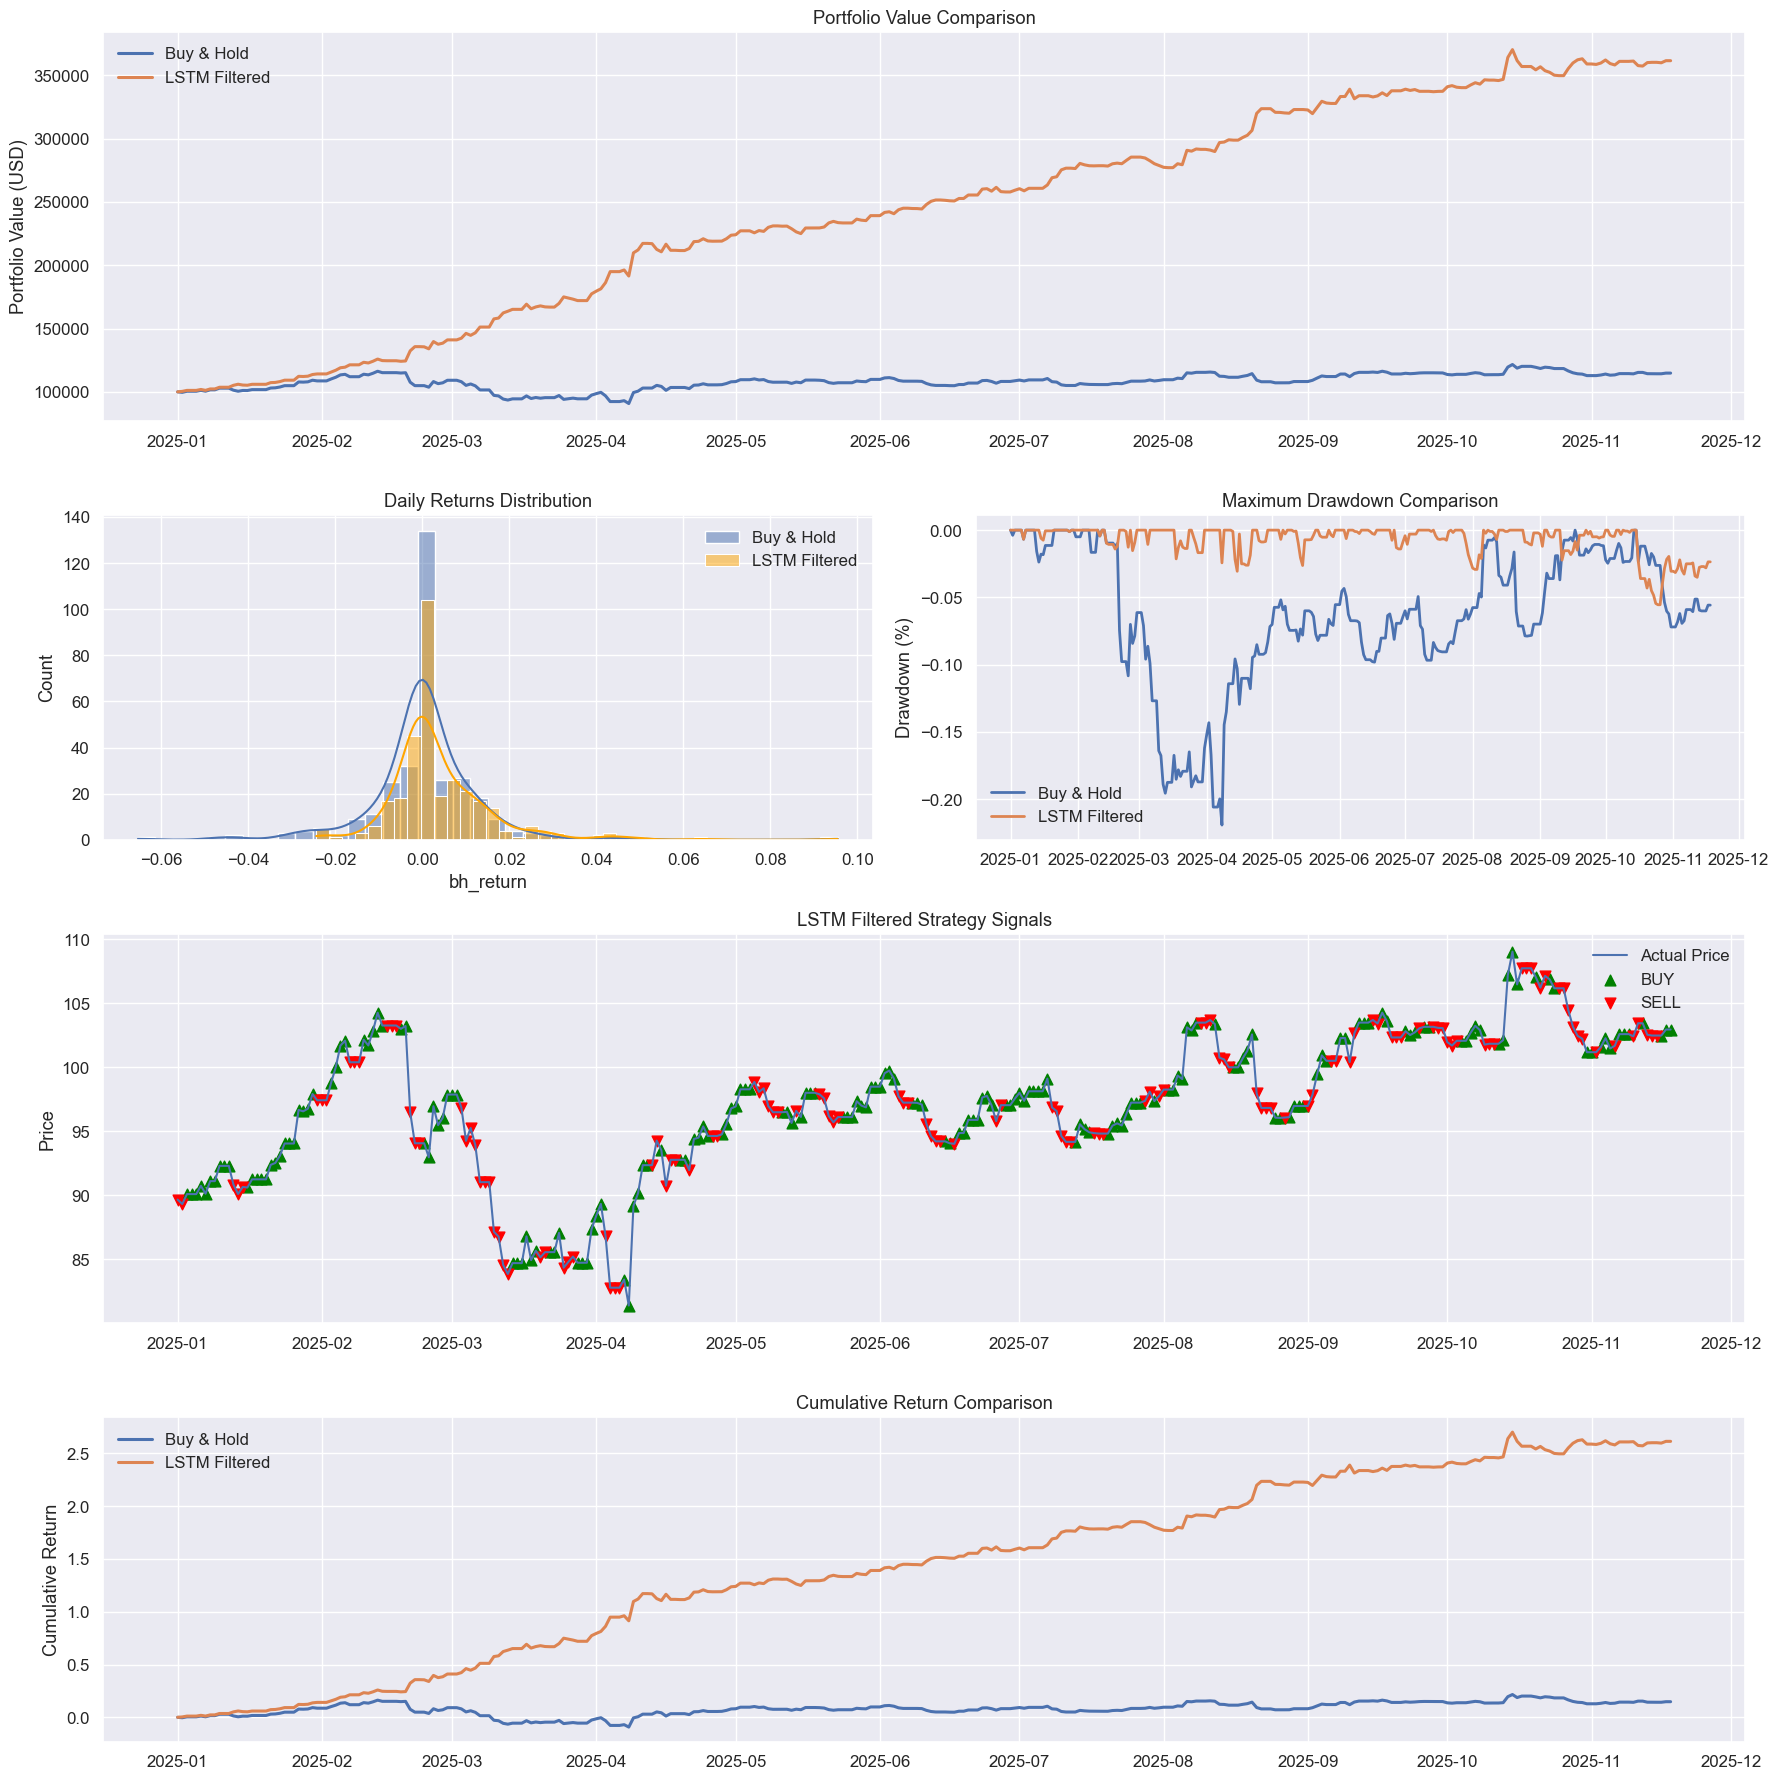

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use("seaborn-v0_8-darkgrid")
sns.set(font_scale=1.1)

# ----------------------------------------------------------
# 1. PREPARE DATA
# ----------------------------------------------------------
dates = df_prices_filt['date']
bh_value = df_prices_filt['bh_portfolio_value']
lstm_value = df_prices_filt['filtered_portfolio_value']
bh_ret = df_prices_filt['bh_return']
lstm_ret = df_prices_filt['filtered_return_net']

# Drawdowns
def compute_drawdown(series):
    cum = (1 + series).cumprod()
    peak = cum.expanding().max()
    dd = (cum - peak) / peak
    return dd

dd_bh = compute_drawdown(bh_ret)
dd_lstm = compute_drawdown(lstm_ret)

# Cumulative Return
cum_bh = (1 + bh_ret).cumprod() - 1
cum_lstm = (1 + lstm_ret).cumprod() - 1

# ----------------------------------------------------------
# 2. CREATE DASHBOARD LAYOUT
# ----------------------------------------------------------
fig = plt.figure(figsize=(18, 18))
grid = fig.add_gridspec(4, 2, height_ratios=[1.2, 1, 1.2, 1])

# ----------------------------------------------------------
# PANEL 1 — Portfolio Value Over Time
# ----------------------------------------------------------
ax1 = fig.add_subplot(grid[0, :])
ax1.plot(dates, bh_value, label="Buy & Hold", linewidth=2.2)
ax1.plot(dates, lstm_value, label="LSTM Filtered", linewidth=2.2)
ax1.set_title("Portfolio Value Comparison")
ax1.set_ylabel("Portfolio Value (USD)")
ax1.legend()

# ----------------------------------------------------------
# PANEL 2 — Daily Return Distribution
# ----------------------------------------------------------
ax2 = fig.add_subplot(grid[1, 0])
sns.histplot(bh_ret, kde=True, bins=40, label="Buy & Hold", ax=ax2)
sns.histplot(lstm_ret, kde=True, bins=40, label="LSTM Filtered", ax=ax2, color='orange')
ax2.set_title("Daily Returns Distribution")
ax2.legend()

# ----------------------------------------------------------
# PANEL 3 — Drawdown Comparison
# ----------------------------------------------------------
ax3 = fig.add_subplot(grid[1, 1])
ax3.plot(dates, dd_bh, label="Buy & Hold", linewidth=2)
ax3.plot(dates, dd_lstm, label="LSTM Filtered", linewidth=2)
ax3.set_title("Maximum Drawdown Comparison")
ax3.set_ylabel("Drawdown (%)")
ax3.legend()

# ----------------------------------------------------------
# PANEL 4 — Trading Signals vs Price
# ----------------------------------------------------------
ax4 = fig.add_subplot(grid[2, :])
ax4.plot(dates, df_prices_filt['actual_price'], label="Actual Price", linewidth=1.5)

buy_idx = df_prices_filt[df_prices_filt['signal_filt'] == 1].index
sell_idx = df_prices_filt[df_prices_filt['signal_filt'] == -1].index

ax4.scatter(dates.iloc[buy_idx], df_prices_filt['actual_price'].iloc[buy_idx],
            marker='^', color='green', s=60, label='BUY')

ax4.scatter(dates.iloc[sell_idx], df_prices_filt['actual_price'].iloc[sell_idx],
            marker='v', color='red', s=60, label='SELL')

ax4.set_title("LSTM Filtered Strategy Signals")
ax4.set_ylabel("Price")
ax4.legend()

# ----------------------------------------------------------
# PANEL 5 — Cumulative Returns
# ----------------------------------------------------------
ax5 = fig.add_subplot(grid[3, :])
ax5.plot(dates, cum_bh, label="Buy & Hold", linewidth=2.2)
ax5.plot(dates, cum_lstm, label="LSTM Filtered", linewidth=2.2)
ax5.set_title("Cumulative Return Comparison")
ax5.set_ylabel("Cumulative Return")
ax5.legend()

# ----------------------------------------------------------
# FINAL
# ----------------------------------------------------------
plt.tight_layout()
plt.show()
